In [4]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import torchattacks
# import scipy 


In [79]:
# print(scipy.__version__)
!pip uninstall torchattacks -y

In [5]:
print(tf.config.list_physical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.15.0


In [6]:
# pathh = 'MNISTClassifier'

# for parent, dirs, files in os.walk(pathh, topdown=False):
#   for file in files:
#     file_path = os.path.join(parent, file)
#     os.remove(file_path)
#   for dir in dirs:
#     dir_path = os.path.join(parent, dir)
#     os.rmdir(dir_path)

# os.rmdir('./MNISTClassifier')

In [9]:
# (images, labels), (test_images, test_labels) = mnist.load_data()
# images = images.reshape((60000, 28, 28)).astype("float32") / 255
# images = np.expand_dims(images, axis=3)
# test_images = test_images.reshape((10000, 28, 28)).astype("float32") / 255
# test_images = np.expand_dims(test_images, axis=3)
# x_train, x_test = images[10000:], images[:10000]
# y_train, y_test = labels[10000:], labels[:10000]

In [10]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28)).astype("float32") / 255
# x_train, x_test = images, test_images
# y_train, y_test = labels, test_labels

In [11]:
train_images.shape

(60000, 28, 28)

In [12]:
train_images = np.asarray([cv2.cvtColor(im, cv2.COLOR_GRAY2RGB) for im in train_images])
test_images = np.asarray([cv2.cvtColor(im, cv2.COLOR_GRAY2RGB) for im in test_images])

In [13]:
train_images = [cv2.resize(im, (64, 64), interpolation=cv2.INTER_NEAREST) for im in train_images]
train_images = np.asarray(train_images)


In [14]:
test_images = [cv2.resize(im, (64, 64), interpolation=cv2.INTER_NEAREST) for im in test_images]
test_images = np.asarray(test_images)


### conver images from HWC to CHW to use torch attacks

In [16]:
height, width, channels = train_images[0].shape

In [54]:
def convert_to_chw(image_arr):
    """
        Params: A list of images or a numpy array of images
        returns: A numpy array of reshaped image from HWC to CHW
    """
    # print(image_arr[0][:,:,0].shape)
    # print(np.max(image_arr[0][:,:,0]))
    # print(np.min(image_arr[0][:,:,0]))
    height, width, channels = image_arr[0].shape
    new_img_arr = []
    for img in image_arr:
        # print(img.shape)
        shape_holder = np.zeros((channels, height, width), dtype=np.float32)
        for channel in range(channels):
            shape_holder[channel] = img[:,:, channel]
        new_img_arr.append(shape_holder)

    return np.array(new_img_arr)

In [45]:
chw_train_images = convert_to_chw(train_images)
chw_test_images = convert_to_chw(test_images)

In [46]:
chw_train_images.shape

(60000, 3, 64, 64)

In [55]:
full_dataset = np.concatenate((train_images, test_images), axis=0)
full_dataset.shape

(70000, 64, 64, 3)

In [56]:
full_dataset.shape

(70000, 64, 64, 3)

In [57]:
full_dataset_label = np.concatenate((train_labels, test_labels), axis=0)
full_dataset_label.shape

(70000,)

In [58]:
# x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, random_state=104, test_size=0.166655, shuffle=True)

In [59]:
x_train, x_test, y_train, y_test = train_test_split(full_dataset,full_dataset_label, random_state=104, test_size=0.1, shuffle=True )

In [60]:
print('x_train.shape', x_train.shape)
print('y_train.shape', y_train.shape)
# print('x_val.shape', x_val.shape)
# print('y_val.shape', y_val.shape)
print('x_test.shape', x_test.shape)
print('y_test.shape', y_test.shape)

x_train.shape (63000, 64, 64, 3)
y_train.shape (63000,)
x_test.shape (7000, 64, 64, 3)
y_test.shape (7000,)


(64, 64, 3)


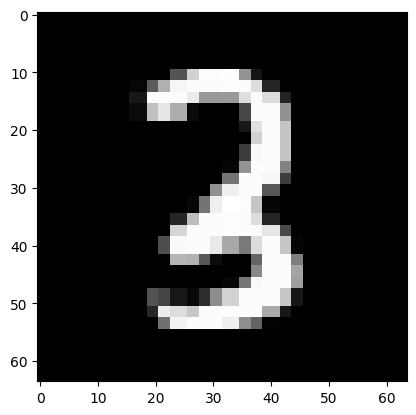

In [61]:
x_test_43 = x_test[35]

print(x_test_43.shape)
digit = x_test_43
fig = plt.figure
plt.imshow(digit)
# print(x_test_43)

#twos are located at [(1, 2), (35, 2), (38, 2), (43, 2), (47, 2), (72, 2), (77, 2), (82, 2), (106, 2), (119, 2)]

In [62]:
# x_test_43 = x_test[35]
# x_test_43

In [63]:
few_twos = []
count = 0
for index, label in enumerate(y_test):
  if count > 9:
    break
  if label == 2:
    few_twos.append((index, label))
    count += 1

print(few_twos)
#select labels that are digit 2

[(11, 2), (20, 2), (24, 2), (37, 2), (46, 2), (56, 2), (60, 2), (65, 2), (68, 2), (78, 2)]


# Networks

## Custom

In [64]:
class MNISTClassifier(tf.keras.Model):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        # Define the layers
        #for feature extration
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3))
        self.max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.dropout1 = tf.keras.layers.Dropout(0.25)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='sigmoid')#might reduce over fitting
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(10)
        self.layers_list = [self.conv1,self.max_pool1, self.conv2,self.max_pool2, self.dropout1,
                           self.flatten, self.dense1, self.dropout2, self.dense2]
    
    @tf.function
    def call(self, *args, **kwargs):
        # Define the forward pass
        # output is the model logits
        activation_list = []
        out = args[0]
        for layer in self.layers_list:
           out = layer(out)
           activation_list.append(out)

        if kwargs['training']:
          #notice that training is a kw argument checked when fit is called
          #so when model is training, all I need is the output logits to call the loss function upon
          return out
        else:
          prob = tf.nn.softmax(out)
          return out, prob

## Backbone Networks

In [65]:
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [66]:
class VGG16model(tf.keras.Model):
    def __init__(self, base_model):
        super(VGG16model, self).__init__()
        #instantiate base model
        self.base_model = base_model
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10)
        self.layers_list = [self.base_model, self.flatten, self.dense1, self.dense2]

    @tf.function
    def call(self, *args, **kwargs):
        # Define the forward pass
        # output is the model logits
        activation_list = []
        out = args[0]
        for layer in self.layers_list:
           out = layer(out)
           activation_list.append(out)

        if kwargs['training']:
          #notice that training is a kw argument checked when fit is called
          #so when model is training, all I need is the output logits to call the loss function upon
          return out
        else:
          prob = tf.nn.softmax(out)
          return out, prob
    

In [67]:
input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
base_model = VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)
base_model.trainable = False



2024-03-15 12:19:52.952399: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-15 12:19:52.952421: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-15 12:19:52.952426: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-15 12:19:52.952491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-15 12:19:52.952511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [68]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## Model fit and saving

In [69]:
class SavefinalTrainingLogitsProp(keras.callbacks.Callback):
    def on_train_end(self, logs):
        self.out = model.predict(x_train)
        self.prob = tf.nn.softmax(self.out)
        print(self.out.shape, self.prob.shape)

In [70]:
def plot_loss_acc(train_metric_values, val_metric_values, type=None, plt_title=None):
    epochs = range(1, len(train_metric_values) +1)
    plt.plot(epochs, train_metric_values, 'bo', label=f'Training {type}')
    plt.plot(epochs, val_metric_values, 'b', label=f'validation {type}')
    plt.title(plt_title)
    plt.xlabel('Epochs')
    plt.ylabel(f'{type}')
    plt.legend()
    plt.show()
    
    

In [71]:
model_custom = MNISTClassifier()
model_custom.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              metrics=['accuracy'])

custom_history = model_custom.fit(x_train, y_train, epochs=10, validation_split=0.2)
# model_custom.save('MNISTClassifier')

Epoch 1/10
   1/1575 [..............................] - ETA: 11:03 - loss: 2.9393 - accuracy: 0.0625

2024-03-15 12:20:03.942110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1575/1575 [==============================] - 16s 10ms/step - loss: 0.2017 - accuracy: 0.9436 - val_loss: 0.0798 - val_accuracy: 0.9772
Epoch 2/10
1575/1575 [==============================] - 15s 9ms/step - loss: 0.0821 - accuracy: 0.9758 - val_loss: 0.0601 - val_accuracy: 0.9824
Epoch 3/10
1575/1575 [==============================] - 15s 10ms/step - loss: 0.0624 - accuracy: 0.9810 - val_loss: 0.0520 - val_accuracy: 0.9841
Epoch 4/10
1575/1575 [==============================] - 15s 9ms/step - loss: 0.0497 - accuracy: 0.9846 - val_loss: 0.0478 - val_accuracy: 0.9867
Epoch 5/10
1575/1575 [==============================] - 15s 9ms/step - loss: 0.0392 - accuracy: 0.9882 - val_loss: 0.0465 - val_accuracy: 0.9863
Epoch 6/10
1575/1575 [==============================] - 15s 9ms/step - loss: 0.0337 - accuracy: 0.9893 - val_loss: 0.0513 - val_accuracy: 0.9849
Epoch 7/10
1575/1575 [==============================] - 15s 9ms/step - loss: 0.0280 - accuracy: 0.9912 - val_loss: 0.0473 - val_accuracy: 0

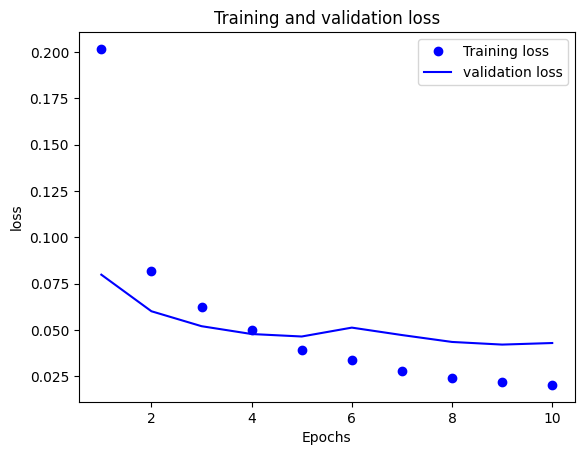

In [72]:
loss_values = custom_history.history["loss"]
val_loss_values = custom_history.history["val_loss"]
plot_loss_acc(loss_values, val_loss_values, type='loss',  plt_title="Training and validation loss")

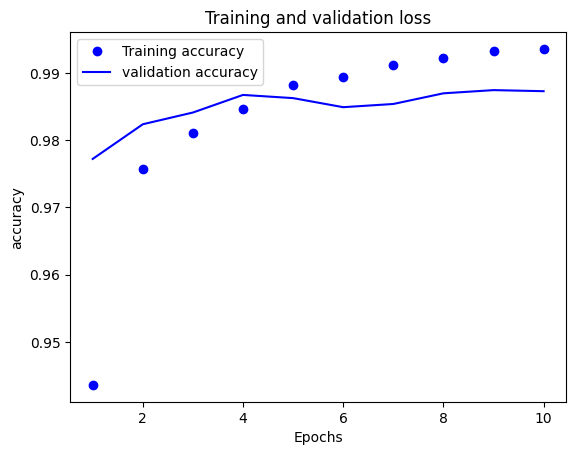

In [73]:
accuracy_values = custom_history.history["accuracy"]
val_accuracy_values = custom_history.history["val_accuracy"]
plot_loss_acc(accuracy_values, val_accuracy_values, type='accuracy',  plt_title="Training and validation loss")

All attacks where carried out using the same epsilon and iteration 
to insure a level palying ground for every attack form

In [74]:
fgsm_attack = torchattacks.FGSM(model_custom)

Failed to set device automatically, please try set_device() manual.


In [75]:
import torch

In [76]:
print(torch.cuda.current_device())

AssertionError: Torch not compiled with CUDA enabled

In [26]:
model_vgg16 = VGG16model(base_model)
model_vgg16.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

vgg16_history = model_vgg16.fit(x_train, y_train, epochs=10, validation_split=0.2) 
# custom_history = model_custom.fit(x_train, y_train, epochs=10, validation_split=0.2)
# model_vgg16.save('VGG16Classifier')

Epoch 1/10
   5/1575 [..............................] - ETA: 22s - loss: 2.4827 - accuracy: 0.1125  

2024-03-11 13:43:50.622224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-11 13:43:50.637995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1575/1575 [==============================] - 35s 22ms/step - loss: 0.1793 - accuracy: 0.9481 - val_loss: 0.0968 - val_accuracy: 0.9685
Epoch 2/10
1575/1575 [==============================] - 34s 22ms/step - loss: 0.0746 - accuracy: 0.9756 - val_loss: 0.0721 - val_accuracy: 0.9763
Epoch 3/10
1575/1575 [==============================] - 34s 22ms/step - loss: 0.0618 - accuracy: 0.9801 - val_loss: 0.0977 - val_accuracy: 0.9692
Epoch 4/10
1575/1575 [==============================] - 35s 22ms/step - loss: 0.0511 - accuracy: 0.9834 - val_loss: 0.0718 - val_accuracy: 0.9769
Epoch 5/10
1575/1575 [==============================] - 35s 22ms/step - loss: 0.0436 - accuracy: 0.9864 - val_loss: 0.0819 - val_accuracy: 0.9750
Epoch 6/10
1575/1575 [==============================] - 35s 22ms/step - loss: 0.0396 - accuracy: 0.9874 - val_loss: 0.0537 - val_accuracy: 0.9837
Epoch 7/10
1575/1575 [==============================] - 34s 22ms/step - loss: 0.0364 - accuracy: 0.9885 - val_loss: 0.0524 - val_accura

# Load model and make predictions

## prepare images and labels

In [32]:
twos_tupple = [(11, 2), (20, 2), (24, 2), (37, 2), (46, 2), (56, 2), (60, 2), (65, 2), (68, 2), (78, 2)]
reshaped_sample_twos = []
class_arr = []

for tup in twos_tupple:
    a_two = x_test[tup[0]]
    print('a_two.shape', a_two.shape)
    a_two = np.reshape(a_two, (-1, 64, 64, 3))
    print('a_two.shape', a_two.shape)
    a_two_label = y_test[tup[0]]
    a_two_label = tf.convert_to_tensor(a_two_label)
    class_arr.append(a_two_label)
    # print(a_two_label)
    reshaped_sample_twos.append(a_two)
reshaped_sample_twos = np.array(reshaped_sample_twos)

a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)
a_two.shape (64, 64, 3)
a_two.shape (1, 64, 64, 3)


In [33]:
print(y_test[37])

2


In [35]:
one_reshaped = reshaped_sample_twos[0]
np.sum(model_custom(one_reshaped)[0])

-29.941143

In [37]:
# model_mnist = tf.keras.models.load_model('MNISTClassifier')

predictions = []
for sample in reshaped_sample_twos:
    sample_prediction = model_custom(sample)
    print('sample_prediction', sample_prediction)
    predictions.append(sample_prediction)
#check a prediction
print(np.argmax(predictions[1][0]))

sample_prediction (<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ -6.1311455,   1.4345764,  10.807065 ,  -1.413912 ,  -6.949984 ,
        -11.085559 ,  -6.404814 ,  -1.4455974,  -2.2879481,  -6.4638224]],
      dtype=float32)>, <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[4.4033879e-08, 8.5023232e-05, 9.9990308e-01, 4.9255536e-06,
        1.9416422e-08, 3.1053612e-10, 3.3491414e-08, 4.7719304e-06,
        2.0552570e-06, 3.1572341e-08]], dtype=float32)>)
sample_prediction (<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-6.698096  , -3.1050892 ,  6.4013247 , -0.25149247, -5.10584   ,
        -7.2670617 , -8.841947  ,  0.33578825,  1.5330733 , -0.04154588]],
      dtype=float32)>, <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[2.0201969e-06, 7.3420350e-05, 9.8718786e-01, 1.2738489e-03,
        9.9289091e-06, 1.1436548e-06, 2.3677255e-07, 2.2917683e-03,
        7.5883102e-03, 1.5714357e-03]], dtype=float32)>)
sample_prediction (<tf.Tensor: shape=(

In [38]:
print(reshaped_sample_twos[0].shape)
# drop first dimension (batch) and prepare for attack
squeze_two = np.squeeze(reshaped_sample_twos[2])
print(squeze_two.shape)
# squeze_two = np.expand_dims(np.squeeze(reshaped_sample_twos[2]), axis=2)
# squeze_two.shape
x = squeze_two
x = np.expand_dims(x, axis=0)
x = tf.convert_to_tensor(x)
y = y_test[35]
y = tf.convert_to_tensor(y)
print(y)
print(x.shape)

(1, 64, 64, 3)
(64, 64, 3)
tf.Tensor(3, shape=(), dtype=uint8)
(1, 64, 64, 3)


In [39]:
# xs = np.array([1, 2, 3])
# xs.ndim

In [40]:
# xs = np.array([xs])
# xs.ndim

# Attack and Plot

In [39]:
def perturb_img(xs, img):
    # print(img.shape, 'in img shape')
    if xs.ndim < 2:
        # if xs has a dim less than 1,
        #add extra dim to it to make it 2
        xs = np.array([xs])
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    # cast xs as int type
    xs = xs.astype(int)

    for x, img in zip(xs, imgs):
        # split x into an array of 5-tuples (pertubation pixels)
        pixels = np.split(x, len(x)//5)
        for pixel in pixels:
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    return imgs
            
        
    
        
    

In [40]:
# x_test_46.shape
predii = model_custom(np.expand_dims(x_test_46, axis=0))[1]
predii

NameError: name 'x_test_46' is not defined

Define a function that runs several perturbed images on a given model and returns the model's confidence (probability output) in the target class, one confidence value per image. If the target class is the correct class, this will be the function that we want to minimize so that the model will be most confident in another class (which is incorrect). Otherwise, the target is an incorrect class and we will want to maximize it.

In [41]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # perturb an image with the given pixel(s) x and return models prediction
    sq_img = np.squeeze(img)
    # print(sq_img.shape, 'img shape')
    imgs_perturbed = perturb_img(xs, sq_img)
    predictions = model(imgs_perturbed)[1][0][target_class]#changed 0 --> 1
    # print('prepre', predictions)

    return predictions if minimize else 1-predictions


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


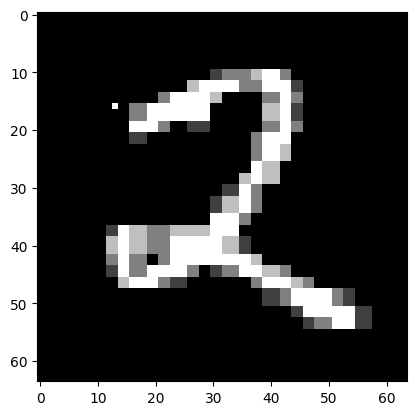

In [179]:
x_test_46 = x_test[46]
y_test_46 = y_test[46]
model = model_custom

pixel = np.array([16, 13, 25, 48, 156])
x_test_46_perturbed = perturb_img(pixel, x_test_46)
x_test_46_perturbed = np.squeeze(x_test_46_perturbed)


plt.imshow(x_test_46_perturbed)

In [44]:
true_class = y_test_46
x_test_46_ = np.expand_dims(x_test_46, axis=0)

print(x_test_46_.shape)
prior_confidence = model.predict(x_test_46_)[1][0][true_class]
confidence = predict_classes(pixel, x_test_46_, true_class, model_custom)
print('prior_confidence', prior_confidence)
print('confidence', confidence)


# pert_img = confidence = predict_classes(pixel, x_test_46_, true_class, model_custom)
# predictions = model(imgs_perturbed)[0][0]

# pred = np.argmax(model(pert_img)[0])
# print('pred', pred)
# plt.imshow(np.squeeze(pert_img))


# predictions = predict_classes()

(1, 64, 64, 3)
1/1 [==============================] - 0s 58ms/step
prior_confidence 0.99996054
confidence tf.Tensor(0.33537173, shape=(), dtype=float32)


In [46]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # perturn image with given pixel(s) and get the model predictions
    attack_image = perturb_img(x, img)
    confidence = model(attack_image)[1][0]
    predicted_class = np.argmax(confidence)
    # print('inside', predicted_class)

    # the function returns True if prediction is what is desired
    # for both targeted attack (prediction matches target class)
    # or misclasification prediction != original class
    if verbose:
        print(f"Confidence: \t {confidence[target_class]}")
    if ((targeted_attack and predicted_class==target_class)or 
        (not targeted_attack and predicted_class != target_class)):
        return True

In [47]:
true_class = y_test_46
pixel = np.array([17, 18, 185, 36, 215])
x_test_46_ = np.expand_dims(x_test_46, axis=0)

print(x_test_46_.shape)
prior_confidence = model(x_test_46_)[0][0][true_class]
success = attack_success(pixel, x_test_46_, true_class, model_custom, verbose=True)
print('prior_confidence', prior_confidence)
print('confidence', success)

(1, 64, 64, 3)
Confidence: 	 0.001666032592765987
prior_confidence tf.Tensor(11.285846, shape=(), dtype=float32)
confidence True


In [137]:
# from differential_evolution import differential_evolution
from scipy.optimize import differential_evolution

In [53]:
reshaped_sample_twos[0].shape

(1, 64, 64, 3)

In [329]:
def one_pixel(img, model, target=None, pixel_count=1, maxiter=75, popsize=400, verbose=False, diff_evo=None):
    img = np.squeeze(img)
    true_img = np.expand_dims(img, axis=0)
    actual_class = np.argmax(model(true_img)[1][0])
    #change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    targeted_class = target if targeted_attack else actual_class
    # Define bounds for a flat vector of x,y,r,g,b
    # repeat this layout for more pixels

    bounds = [(0,64),(0, 64),(0,255),(0,255),(0,255)]

    # Population multiplier in terms if the size of perturbation vector x
    popmul = max(1, popsize//len(bounds))

    # format the predict/callback function for the DE
    def predict_fn(xs):
        return predict_classes(xs, img, targeted_class, model, target is None)

    def callback_fn(x, convergence):
        return attack_success(x, img, targeted_class, model, targeted_attack, verbose)

    #Call the Scipy implementation of DE
    attack_result = diff_evo(predict_fn, bounds, maxiter=maxiter,
                                          popsize=popmul, recombination=0.2, atol=1, callback=callback_fn,
                                          polish=False)

    # print('almost')
    #Calculate some useful statistics to return from this function
    attack_image = perturb_img(attack_result.x, img)[0]
    r_attack_img = np.expand_dims(attack_image, axis=0)
    prior_probs = model(true_img)[0][0]
    predicted_probs = model(r_attack_img)[0][0]
    predicted_class = np.argmax(predicted_probs)
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # verbose = True
    if verbose == True:
        print(f'predicted_class: {predicted_class} \t true_class: {actual_class}')
    # attack_result =  differential_evolution(None, None)

    # Show the best attempt at a solution (successful or not)
    # helper.plot_image(attack_image, actual_class, class_names, predicted_class)
    # results.append([model.name, pixel_count, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x])

    results = (attack_image, img, attack_result.x) 
    return results


    

In [255]:
loop_results = []
for img in reshaped_sample_twos:
    from scipy.optimize import differential_evolution as diff_evo
    pixel = 1
    model = model_custom

    cur_res = one_pixel(img, model, pixel_count=pixel, verbose=False, diff_evo=diff_evo)
    loop_results.append(cur_res)
    

predicted_class* 5
predicted_class* 5
predicted_class* 7
predicted_class* 7
predicted_class* 5
predicted_class* 5
predicted_class* 7
predicted_class* 5
predicted_class* 5
predicted_class* 6


In [271]:
adv_img = loop_results[4][0]
org_img = loop_results[0][1]
pixels = loop_results[0][-1]
np.argmax(model_custom(np.expand_dims(adv_img, axis=0))), np.argmax(model_custom(np.expand_dims(org_img, axis=0))), pixels


(5,
 2,
 array([ 17.25343712,  49.94845319, 194.0796345 ,  75.68809059,
        170.80733235]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


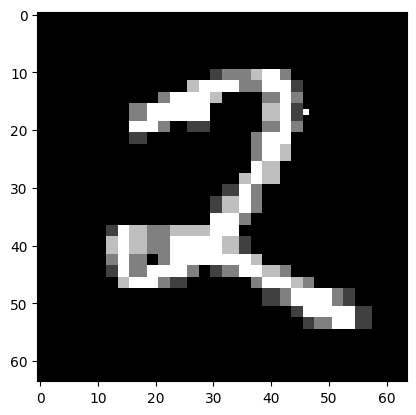

In [272]:
# cmap = plt.cm.LinearSegmentedColormap.from_list('my_cmap', ['red', 'blue'])

plt.imshow(adv_img, cmap='coolwarm')

In [273]:
# # x_test_46 = x_test[46]
# img = reshaped_sample_twos[0]
# pixel = 1
# model = model_custom

# results_0 = one_pixel(img, model, pixel_count=pixel, verbose=False, diff_evo=differential_evolution)

# # results = attack(image_id, model, pixel_count=pixel, verbose=False)

In [274]:
# adv_img = results_0[0]
# org_img = results_0[1]
# pixels = results_0[-1]
# np.argmax(model_custom(np.expand_dims(adv_img, axis=0))), np.argmax(model_custom(np.expand_dims(org_img, axis=0))), pixels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


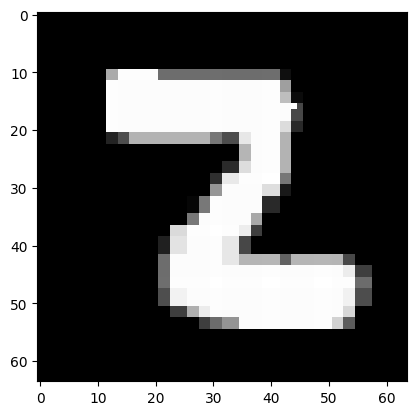

In [247]:
plt.imshow(adv_img)

In [276]:
# # x_test_46 = x_test[46]
# img = reshaped_sample_twos[8]
# pixel = 1
# model = model_custom

# results_6 = one_pixel(img, model, pixel_count=pixel, verbose=False, diff_evo=differential_evolution)

# # results = attack(image_id, model, pixel_count=pixel, verbose=False)

In [275]:
# print(results[-1])

## Batch attack

loop_results = []
for img in reshaped_sample_twos:
    from scipy.optimize import differential_evolution as diff_evo
    pixel = 1
    model = model_custom

    cur_res = one_pixel(img, model, pixel_count=pixel, verbose=False, diff_evo=diff_evo)
    loop_results.append(cur_res)

# Batch distance measure

In [29]:
# adv_image = np.squeeze(attack_results[0][0])
# adv_image = np.expand_dims(adv_image, axis=2)
# org_image = np.expand_dims(np.squeeze(reshaped_sample_twos[0]), axis=2)
# perturbation = np.expand_dims(np.squeeze(attack_results[0][1]), axis=2)
# org_image.shape
# adv_image.shape

In [284]:
loop_results[0][-1].shape

(5,)

In [285]:
def batch_distance_measure(loop_results):
    l2_norm_distance = []
    for tup in loop_results:
        cur_adv_img = tup[0]
        cur_img = tup[1]
        distance = np.linalg.norm(cur_adv_img - cur_img)
        distance = format(distance, '.2f')
        l2_norm_distance.append(distance)
    return l2_norm_distance
        

In [93]:
# l2_norm_distance = batch_distance_measure(attack_results, reshaped_sample_twos)
# print(l2_norm_distance)

In [286]:
l2_norm_distance = batch_distance_measure(loop_results)
print(l2_norm_distance)

['268.63', '268.00', '375.41', '270.48', '232.70', '181.67', '349.51', '267.53', '311.56', '296.21']


# Visualize predictions and images

In [89]:
# fig = plt.figure(figsize=(10, 10))

# rows = 1
# columns = 3

# fig.add_subplot(rows, columns, 1)
# plt.imshow(org_image, cmap='gray')
# plt.axis('off')
# plt.title(f'Original Image \n predictions: {org_pred}')

# fig.add_subplot(rows, columns, 2)
# plt.imshow(perturbation, cmap='gray')
# plt.axis('off')
# plt.title(f'Pertubation\n /Distance: {distance}')

# fig.add_subplot(rows, columns, 3)
# plt.imshow(adv_image, cmap='gray')
# plt.axis('off')
# plt.title(f'Adversarial Image \n Prediction: {adv_pred}')

In [96]:
predi = model_custom.predict(reshaped_sample_twos[0])
reshaped_sample_twos[0].shape
attack_results[0][0].shape
predioo = model_custom.predict(attack_results[0][0])
print(np.argmax(predi), np.argmax(predioo))

1/1 [==============================] - 0s 10ms/step
2 5


In [289]:
def batch_visualization(loop_arr, model=None):
    total_plots = len(loop_arr)
    rows = total_plots
    columns = 2
    for idx in range(total_plots):
        cur_org_img = loop_arr[idx][1]
        fig = plt.figure(figsize=(10, 10))
        org_pred = model.predict(np.expand_dims(cur_org_img, axis=0))
        list_org_pred = list(org_pred)
        list_org_pred = list_org_pred[1][0]
        org_pred_cls = np.argmax(org_pred)
        org_conf = round(list_org_pred[org_pred_cls], 1)
        # cur_org_img = loop_arr[idx][1]
        fig.add_subplot(rows, columns, 1)
        # cur_org_img_sq = np.squeeze(cur_org_img)
        plt.imshow(cur_org_img, cmap='hot')
        plt.axis('off')
        plt.title(f'Original Image \n predictions: {org_pred_cls} \n ')

        # cur_dist = dist_arr[idx]
        # fig.add_subplot(rows, columns, 2)
        # cur_pert_img = np.squeeze(perturbation)
        # plt.imshow(cur_pert_img, cmap='hot')
        # plt.axis('off')
        # plt.title(f'Pertubation\n /Distance: {cur_dist}')

        cur_adv_img = loop_arr[idx][0]
        adv_pred = model.predict(np.expand_dims(cur_adv_img, axis=0))
        adv_pred_cls = np.argmax(adv_pred)
        list_adv_pred = list(adv_pred)
        list_adv_pred = list_adv_pred[1][0]
        adv_conf = format(list_adv_pred[adv_pred_cls], '.1f')
        # cur_adv_img_sq = np.squeeze(cur_adv_img)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(cur_adv_img, cmap='hot')
        plt.axis('off')
        plt.title(f'Adversarial Image \n Prediction: {adv_pred_cls} \n Confidence {adv_conf}')
        
    plt.show()

1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 7ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


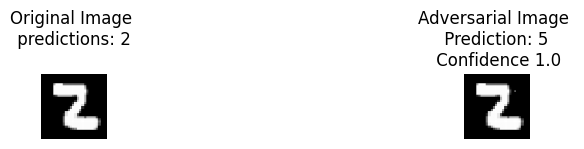

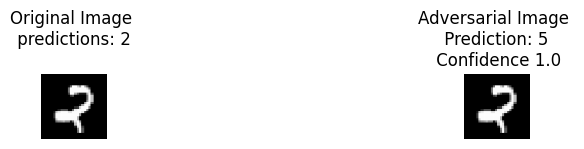

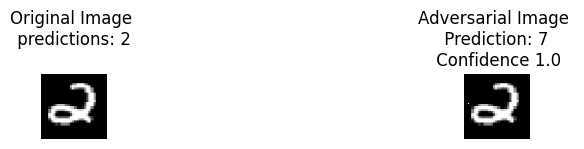

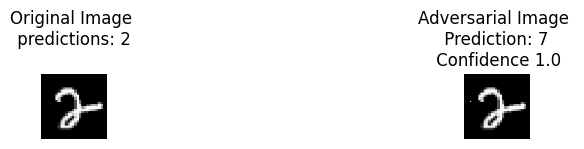

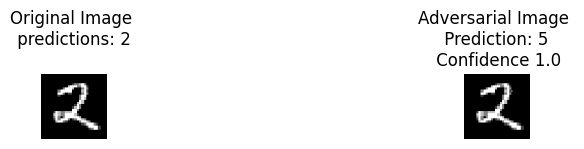

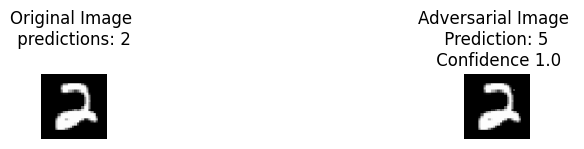

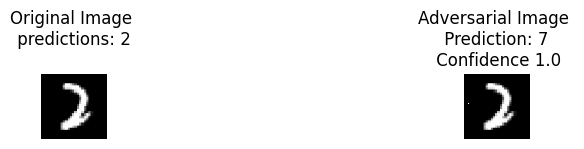

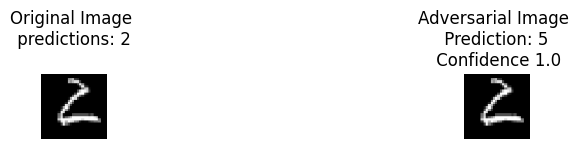

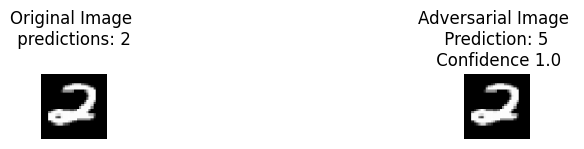

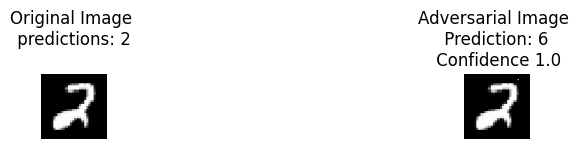

In [290]:
batch_visualization(loop_results, model=model_custom)

In [174]:
batch_visualization(attack_results, reshaped_sample_twos, l2_norm_distance, model=model_custom)

NameError: name 'l2_norm_distance' is not defined

## Model Evaluation after Perturbation

In [299]:
# x_test, y_train, y_test
x_test_2000 = x_test[:2000]
y_test_2000 = y_test[:2000]
r_x_test_2000 = np.asanyarray([np.expand_dims(img, axis=0) for img in x_test_2000])
x_test_2000.shape, r_x_test_2000[0].shape, reshaped_sample_twos[0].shape
# r_x_test_2000 = np.asanyarray([np.expand_dims(img) for img in x_test_2000])

((2000, 64, 64, 3), (1, 64, 64, 3), (1, 64, 64, 3))

### perturb test set

In [324]:
THRESHHOLD = 0.25

In [332]:
def perturb_test_set(test_set, threshhold, verbose=True):
    quota = int(threshhold * len(test_set))
    print(quota)
    img_to_perturb = test_set[:quota]
    
    print(f'len(test_set): {len(test_set)}   quota: { quota}  img_to_perturb: {len(img_to_perturb)} ')
    
    perturbed_test_set = []
    
    for idx, img in enumerate(img_to_perturb):
        print(f'{idx}/{quota}')
        from scipy.optimize import differential_evolution as diff_evo
        pixel = 1
        model = model_custom
    
        cur_res = one_pixel(img, model, pixel_count=pixel, verbose=False, diff_evo=diff_evo)
        perturbed_test_set.append(cur_res[0])
    return perturb_test_set
        

In [326]:
# perturbed_test_set = []
# for img in r_x_test_2000:
#     from scipy.optimize import differential_evolution as diff_evo
#     pixel = 1
#     model = model_custom

#     cur_res = one_pixel(img, model, pixel_count=pixel, verbose=False, diff_evo=diff_evo)
#     loop_results.append(cur_res[0])

In [333]:
perturb_test_set(r_x_test_2000, THRESHHOLD)

500
len(test_set): 2000   quota: 500  img_to_perturb: 500 
0/500
1/500
2/500
3/500
4/500
5/500
6/500
7/500
8/500
9/500
10/500
11/500
12/500
13/500
14/500
15/500
16/500
17/500
18/500
19/500
20/500
21/500
22/500
23/500
24/500
25/500
26/500
27/500
28/500
29/500
30/500
31/500
32/500
33/500
34/500
35/500
36/500
37/500
38/500
39/500
40/500
41/500
42/500
43/500
44/500
45/500
46/500
47/500
48/500
49/500
50/500
51/500
52/500
53/500
54/500
55/500
56/500
57/500
58/500
59/500
60/500
61/500
62/500
63/500
64/500
65/500
66/500
67/500
68/500
69/500
70/500
71/500
72/500
73/500
74/500
75/500
76/500
77/500
78/500
79/500
80/500
81/500
82/500
83/500
84/500
85/500
86/500
87/500
88/500
89/500
90/500
91/500
92/500
93/500
94/500
95/500
96/500
97/500
98/500
99/500
100/500
101/500
102/500
103/500
104/500
105/500
106/500
107/500
108/500
109/500
110/500
111/500
112/500
113/500
114/500
115/500
116/500
117/500
118/500
119/500
120/500
121/500
122/500
123/500
124/500
125/500
126/500
127/500
128/500
129/500
130/500
131

KeyboardInterrupt: 